In [10]:
import numpy as np
import pandas as pd
import pickle
import gzip

from joblib import Parallel, delayed
import multiprocessing
from index_helpers import load_Kp
import matplotlib.pyplot as plt
import os
import itertools
import random
import os
import time
import datetime as datetime
import types
import scipy.io
import matplotlib.gridspec as gridspec


from scipy import stats
import xflib
import logging
import math
from mpl_toolkits.mplot3d import Axes3D
#%matplotlib inline
%matplotlib nbagg
# Autoload changes made in external editor:
%load_ext autoreload
%autoreload 2

from mpl_toolkits.axes_grid1 import make_axes_locatable
xf = xflib.xflib(lib_path='/shared/users/asousa/WIPP/3dWIPP/python/libxformd.so')
from scipy.integrate import nquad

from GLD_file_tools import GLD_file_tools


# --------------- Latex Plot Beautification --------------------------
fig_width = 12 
fig_height = 4
fig_size =  [fig_width+1,fig_height+1]
params = {'backend': 'ps',
          'axes.labelsize': 14,
          'font.size': 14,
          'legend.fontsize': 14,
          'xtick.labelsize': 14,
          'ytick.labelsize': 14,
          'text.usetex': False,
          'figure.figsize': fig_size}
plt.rcParams.update(params)
# --------------- Latex Plot Beautification --------------------------

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
# Convert the Matlab coastline datafile to geomagnetic coordinates:
def get_coast_mag(itime):
    xf = xflib.xflib(lib_path='/shared/users/asousa/WIPP/3dWIPP/python/libxformd.so')
    coastlines = scipy.io.loadmat('coastlines.mat')

    coast_lat_mag = np.zeros(len(coastlines['lat']))
    coast_lon_mag = np.zeros(len(coastlines['long']))

    for ind, (lat, lon) in enumerate(zip(coastlines['lat'], coastlines['long'])):
        if np.isnan(lat) or np.isnan(lon):
            coast_lat_mag[ind] = np.nan
            coast_lon_mag[ind] = np.nan
        else:
            tmpcoords = [1, lat[0], lon[0]]
            tmp_mag = xf.rllgeo2rllmag(tmpcoords, itime)
            coast_lat_mag[ind] = tmp_mag[1]
            coast_lon_mag[ind] = tmp_mag[2]

    # Loop around for -180 + 180 ranges
    coast_lat_mag = np.concatenate([coast_lat_mag, coast_lat_mag[coast_lon_mag > 180]])
    coast_lon_mag = np.concatenate([coast_lon_mag, (coast_lon_mag[coast_lon_mag > 180] - 360)])

    # Toss in some NaNs to break up the continents
    for ind in range(len(coast_lat_mag) -1):
        if ((np.abs(coast_lat_mag[ind+1] - coast_lat_mag[ind]) > 5) or
           (np.abs(coast_lon_mag[ind+1] - coast_lon_mag[ind]) > 5)):
            coast_lat_mag[ind] = np.nan
            coast_lon_mag[ind] = np.nan

    return coast_lat_mag, coast_lon_mag
#     fig, ax = plt.subplots(2,1)
#     ax[0].plot(coast_lon_mag, coast_lat_mag, 'b')
#     ax[0].plot(coastlines['long'],coastlines['lat'],'r')

In [13]:
# Load input power database:
with gzip.open('../outputs/inp_pwr_db_1deg_bins.pklz','rb') as f:
    inp_pwr_dict = pickle.load(f)
# print d.keys()

tmp = np.array(sorted([k for k in inp_pwr_dict.keys() if not isinstance(k, basestring)]))

# for k in tmp:
#     print k, (10000.0**2.0)*np.sum(d[(k[0], k[1])])
stencil_lats = np.unique(tmp[:,0]); stencil_MLTs = np.unique(tmp[:,1])
# print stencil_lats
cellsize = inp_pwr_dict['cellsize']
cell_lat_offset = np.round(inp_pwr_dict['lat_spread']/inp_pwr_dict['cellsize'])
cell_lon_offset = np.round(inp_pwr_dict['lon_spread']/inp_pwr_dict['cellsize'])

gridlats = np.arange(-90, 90, cellsize)
gridlons = np.arange(-180, 180, cellsize)
gridmlts = np.linspace(0,24, 9) #np.array([0,6,12,18,24])

# print cell_lat_offset, cell_lon_offset

# plt.figure(); plt.imshow(np.log10(d[(50,0)]))

In [4]:
def data_grid_at(in_time):
#     print np.shape(times_to_do)
    print "loading flashes at ", in_time
    data_grid = []
#     for in_time in times_to_do:

    Kpm = Kpmax[Kpmtimes == in_time]
    Kp_cur = Kp[np.where(Ktimes == in_time)[0]]

    flashes, flash_times = gld.load_flashes(in_time, lookback_time)
    print np.shape(flashes)
    for flash, flashtime in zip(flashes, flash_times):

        glat = flash[7]
        glon = flash[8]
        I    = flash[9]

        # Get location in geomagnetic coordinates
        mloc = xf.rllgeo2rllmag([1.0, glat, glon], flashtime)

        # Get MLT:
        mlt = xf.lon2MLT(flashtime, mloc[2])

        data_grid.append([mloc[1], mloc[2], mlt, I, Kpm, Kp_cur])
    data_grid = np.array(data_grid)
    return data_grid



In [14]:
# Output power space:
def analyze_flashes(data_grid, in_time):

    outdata = dict()
    dg2 = np.array(data_grid)

    # Quantize data into lat, lon, and MLT bins:
    dg2[:,0] = np.digitize(dg2[:,0],gridlats)
    dg2[:,1] = np.digitize(np.mod(dg2[:,1], 360.0) - 180.0, gridlons)
    dg2[:,2] = (dg2[:,2] > 6) & (dg2[:,2] <= 18)   # Is day?

    hist_bins = np.arange(0,24.5, 0.5)
    flash_map = np.zeros([len(gridlats), len(gridlons)])
    cur_map   = np.zeros([len(gridlats), len(gridlons)])
    pwr_map   = np.zeros([len(gridlats), len(gridlons)])
    mlt_hist, _  = np.histogram(data_grid[:,2], hist_bins)
#     print np.shape(mlt_hist)

#     fig, ax = plt.subplots(1,1)
#     ax.bar(hist_bins[0:-1], mlt_hist)

    # Bin total current by lat and lon
    day_bins = np.zeros([len(gridlats), len(gridlons)])
    nite_bins= np.zeros([len(gridlats), len(gridlons)])

    
    for row in dg2:
        # Power stencils are proportional to current squared;
        # GLD currents are in kA
        if row[2]:
            day_bins[int(row[0]), np.mod(int(row[1]), 360)] += pow(row[3]*1e3, 2.0)
        else:
            nite_bins[int(row[0]), np.mod(int(row[1]), 360)] += pow(row[3]*1e3, 2.0)
        
        # Flash count histogram
        flash_map[int(row[0]), np.mod(int(row[1]), 360)] += 1
        
        # 2d current histogram
        flash_map[int(row[0]), np.mod(int(row[1]), 360)] += np.abs(row[3]*1e3)



    day_todo = np.where(day_bins > 0)
    nite_todo = np.where(nite_bins > 0)

    for isday in [False, True]:
        if isday:
            todo = np.where(day_bins > 0)
        else:
            todo = np.where(nite_bins > 0)
        for latind, lonind in zip(todo[0], todo[1]):
            if (np.abs(gridlats[latind]) >= stencil_lats[0]) & (np.abs(gridlats[latind]) <= stencil_lats[-1]):
                key = (np.abs(np.round(gridlats[latind])), 0)
                if key in inp_pwr_dict:
                    stencil = inp_pwr_dict[key]
                    if isday:
                        pwr = day_bins[latind, lonind]
                    else:
                        pwr = nite_bins[latind, lonind]
                    latleft = int(latind - cell_lat_offset)
                    latright = int(latind + cell_lat_offset-1)
                    lonleft = int(lonind - cell_lon_offset)
                    lonright =int(lonind + cell_lon_offset-1)

                    if lonleft < 0:
                        # Wrap around left:
                        pwr_map[latleft:latright, 0:lonright] += \
                                stencil[:, np.abs(lonleft):]*pwr
                        pwr_map[latleft:latright, (len(gridlons) - np.abs(lonleft)):] += \
                                stencil[:,0:np.abs(lonleft)]*pwr
                    elif lonright >= len(gridlons):
                        # wrap around right:
                        pwr_map[latleft:latright, lonleft:len(gridlons)] += \
                            stencil[:,0:len(gridlons) - lonleft]*pwr
                        pwr_map[latleft:latright, 0:np.abs(lonright) - len(gridlons)] += \
                            stencil[:,len(gridlons) - lonleft:]*pwr
                    else:
                        pwr_map[latleft:latright, lonleft:lonright] += stencil*pwr

    outdata['pwr_map'] = pwr_map
    outdata['flash_map'] = flash_map
    outdata['cur_map'] = cur_map
    outdata['mlt_hist'] = mlt_hist
    outdata['in_time'] = in_time
    return outdata

def plot_pwr_data(outdata):
    # --------------- Latex Plot Beautification --------------------------
    fig_width = 12 
    fig_height = 6
    fig_size =  [fig_width+1,fig_height+1]
    params = {'backend': 'ps',
              'axes.labelsize': 14,
              'font.size': 14,
              'legend.fontsize': 14,
              'xtick.labelsize': 14,
              'ytick.labelsize': 14,
              'text.usetex': False,
              'figure.figsize': fig_size}
    plt.rcParams.update(params)
    # --------------- Latex Plot Beautification --------------------------
    
    pwr_map = outdata['pwr_map']
    flash_map = outdata['flash_map']
    cur_map = outdata['cur_map']
    mlt_hist = outdata['mlt_hist']
    in_time = outdata['in_time']
    # Plot flash location with integrated current vs lat and lon:
    fig = plt.figure()
    gs = gridspec.GridSpec(2,3,width_ratios=[0.5,10,0.25],
                       height_ratios=[10,1])
    # gs.update(left=0.05, right=0.48, wspace=0.05)
    ax1 = plt.subplot(gs[0:-1,1:-1])  # main figure
    ax0 = plt.subplot(gs[0:-1,0])   #
    ax2 = plt.subplot(gs[-1,1:-1])
    cbar_ax = plt.subplot(gs[:, -1])
    pwr_bylat = np.sum(pwr_map, axis=1)/lookback_time.total_seconds()
    pwr_bylon = np.sum(pwr_map, axis=0)/lookback_time.total_seconds()
    
    logpwr = np.log10(pwr_map/3600./3.0)  # Energy per second, in log space.
    logpwr[np.isinf(logpwr)] = -10


#     p = ax1.pcolorfast(gridlons, gridlats, logpwr, cmap = plt.get_cmap('jet'))
    p = ax1.pcolorfast(gridlons, gridlats, logpwr, cmap = plt.get_cmap('viridis'))
    cbar = plt.colorbar(p, cax=cbar_ax)
    

#     for v in [True,False]:
#         if v:
#             label = 'Day'; marker = 'w.'
#         else:
#             label = 'Night'; marker = 'w.'
#         ax1.plot(data_grid[dg2[:,2]==v,1]-180.0, data_grid[dg2[:,2]==v,0],marker, label=label, alpha=0.1)

    coast_lat_mag, coast_lon_mag = get_coast_mag(in_time)
    ax1.plot(coast_lon_mag, coast_lat_mag, 'w')
    ax1.set_xlim([-180, 180])
    ax1.set_ylim([-90, 90])
    p.set_clim([0,4])
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax0.plot(pwr_bylat,gridlats)
    ax0.set_ylim([-90,90])
    ax0.set_xticks([])
    ax0.set_ylabel('Latitude (magnetic)')
    ax2.plot(gridlons, pwr_bylon)
    ax2.set_xlim([-180,180])
    ax2.set_yticks([])
    ax2.set_xlabel('Longitude (magnetic)')

    ax1.set_title( in_time.isoformat() )
    fig.tight_layout()

# analyze_flashes(data_grid)

loading flashes at  2015-01-07 06:00:00
loading flashes at  2015-01-07 09:00:00
loading flashes at  2015-01-07 12:00:00
(4063, 10)
(5872, 10)
(5881, 10)


<IPython.core.display.Javascript object>


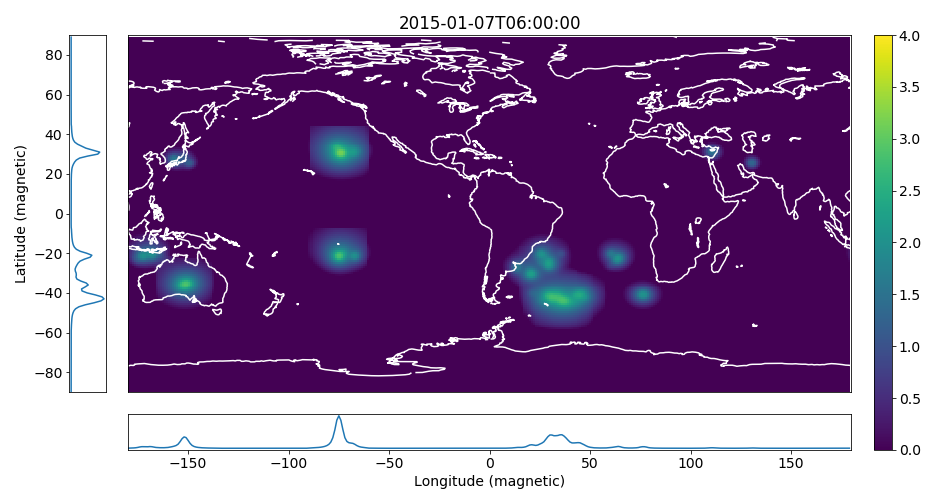

<IPython.core.display.Javascript object>


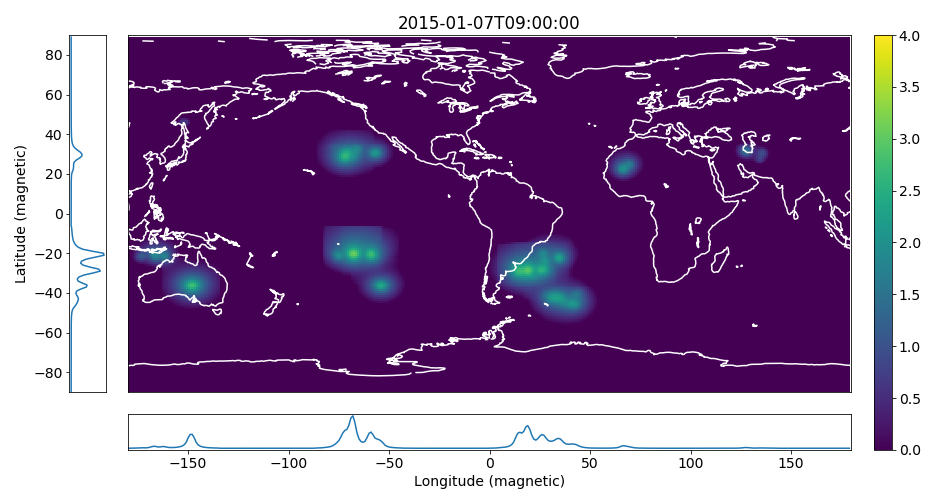

<IPython.core.display.Javascript object>


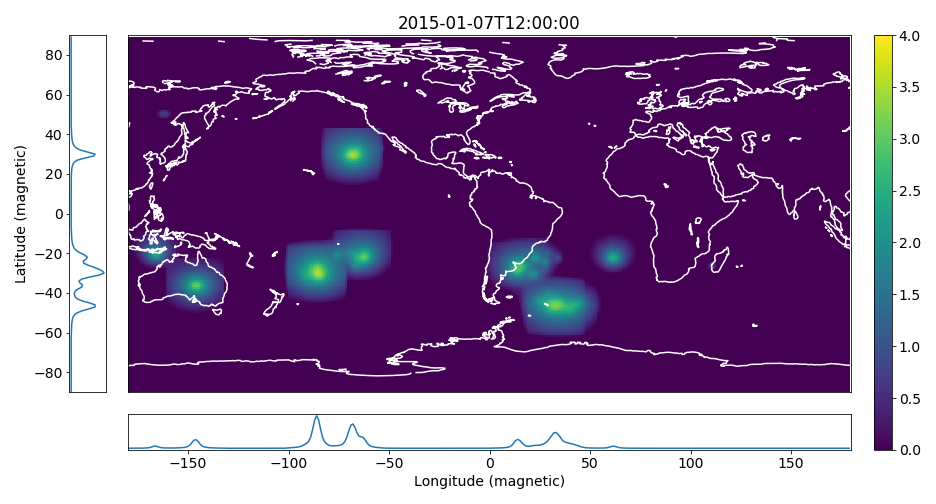

In [15]:
# ------------- This is the main run block! ---------------

# Get Kp data
Ktimes, Kp = load_Kp()
Ktimes = [k + datetime.timedelta(minutes=90) for k in Ktimes]  # 3-hour bins; the original script labeled them in the middle of the bin
Ktimes = np.array(Ktimes)
Kp = np.array(Kp)

# Get Kpmax -- max value of Kp over the last 24 hours (8 bins):
Kpmax = np.max([Kp[0:-8],Kp[1:-7],Kp[2:-6], Kp[3:-5], Kp[4:-4],Kp[5:-3],Kp[6:-2], Kp[7:-1], Kp[8:]],axis=0)
Kpmtimes = Ktimes[8:]

# The range of times we'll do:
start_time = datetime.datetime(2015,1,7,3,0,0)
stop_time = datetime.datetime(2015,1,7,12,0,0)

# Lightning data getter
GLD_path = '/home/asousa/GLD_mount/'
gld = GLD_file_tools(GLD_path, prefix='GLD')

# How far back before in_time do we want to look for (3 hrs)
# lookback_time = datetime.timedelta(hours=3)
lookback_time = datetime.timedelta(minutes=5)

num_cores = multiprocessing.cpu_count()

times_to_do = Ktimes[(Ktimes > start_time) & (Ktimes <= stop_time)]

def job(intime):
    datagrid = data_grid_at(intime)
    return analyze_flashes(datagrid, intime)
    
datae = Parallel(n_jobs=num_cores)(delayed(job)(t) for t in times_to_do)

for datum in datae:
    plot_pwr_data(datum)
# plot_pwr_data(job(start_time))
# job(stop_time)

<IPython.core.display.Javascript object>


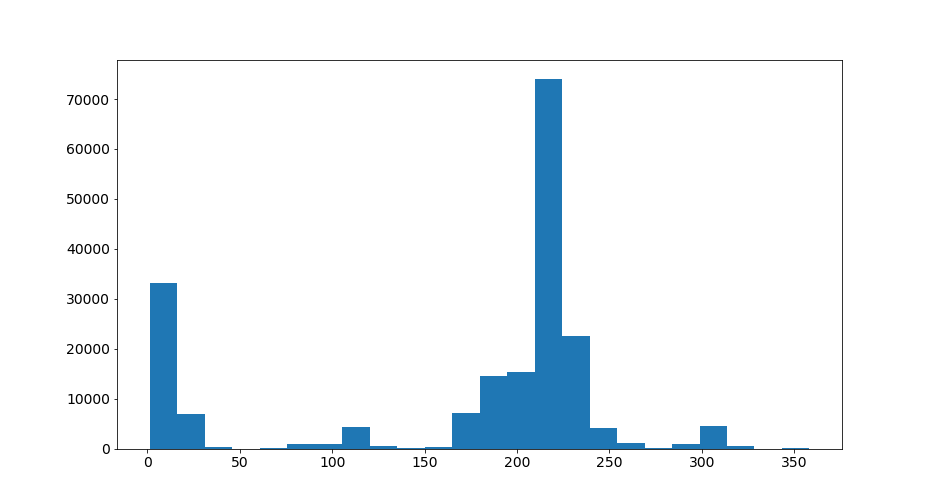

(array([  3.31760000e+04,   7.01700000e+03,   3.81000000e+02,
          7.00000000e+00,   3.30000000e+01,   8.54000000e+02,
          9.96000000e+02,   4.30800000e+03,   4.36000000e+02,
          6.20000000e+01,   3.97000000e+02,   7.18700000e+03,
          1.45420000e+04,   1.53230000e+04,   7.40140000e+04,
          2.25290000e+04,   4.11800000e+03,   1.10900000e+03,
          4.80000000e+01,   9.94000000e+02,   4.51400000e+03,
          5.40000000e+02,   0.00000000e+00,   2.90000000e+01]),
 array([   1.39102048,   16.25957225,   31.12812403,   45.99667581,
          60.86522759,   75.73377937,   90.60233115,  105.47088293,
         120.3394347 ,  135.20798648,  150.07653826,  164.94509004,
         179.81364182,  194.6821936 ,  209.55074538,  224.41929716,
         239.28784893,  254.15640071,  269.02495249,  283.89350427,
         298.76205605,  313.63060783,  328.49915961,  343.36771139,
         358.23626316]),
 <a list of 24 Patch objects>)

In [375]:
fig, ax = plt.subplots(1,1)
ax.hist(data_grid[:,1],24)


In [104]:
# Load dictionary of power densities:
with gzip.open('../outputs/inp_pwr_db.pklz','rb') as f:
    inp_pwrs = pickle.load(f)
    
flash_grid = []
for flash, flashtime in zip(flashes, flash_times):
    glat = flash[7]
    glon = flash[8]
    I    = flash[9]
    
    # Get location in geomagnetic coordinates
    mloc = xf.rllgeo2rllmag([1.0, glat, glon], flashtime)
    
    # Get MLT:
    mlt = xf.lon2MLT(flashtime, mloc[2])
    
    flash_grid.append([mloc[1], mloc[2], mlt,I])

# n_flashes x (mlat, mlon, MLT, I)
flash_grid = np.array(flash_grid)

-345.0 -165.0


<IPython.core.display.Javascript object>


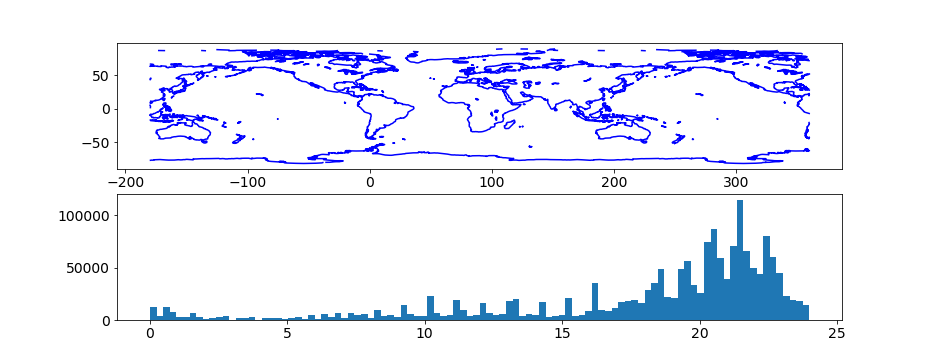

(array([  12447.,    4492.,   12422.,    7521.,    3533.,    2854.,
           6570.,    3173.,    1355.,    2729.,    3226.,    4041.,
            551.,    2197.,    2530.,    3478.,     640.,    2551.,
           2133.,    2444.,    1338.,    2161.,    3515.,    1739.,
           4723.,    1619.,    6251.,    2868.,    7300.,    2535.,
           6756.,    5211.,    6348.,    2396.,   10005.,    4262.,
           5224.,    2765.,   15110.,    6485.,    4569.,    4485.,
          23246.,    7416.,    4331.,    5332.,   19778.,    9886.,
           4134.,    4750.,   16292.,    6598.,    4956.,    5620.,
          18194.,   20251.,    4329.,    5839.,    4863.,   17518.,
           3604.,    3788.,    5208.,   21394.,    4518.,    5416.,
           9285.,   35332.,    9497.,    8503.,   11532.,   17816.,
          18331.,   19693.,   16717.,   28867.,   35544.,   48754.,
          22402.,   21775.,   49112.,   56097.,   33817.,   25891.,
          74655.,   87107.,   59110.,   38913., 

In [105]:
# Either use these directly, or reduce the set via kmeans.

midnite_lon = xf.MLT2lon(in_time, 0)
noon_lon    = xf.MLT2lon(in_time, 12)
print midnite_lon, noon_lon
fig, ax = plt.subplots(2,1)
ax[0].plot(coast_lon_mag, coast_lat_mag, 'b')
# ax[0].plot(flash_grid[:,1], flash_grid[:,0], 'r.')
# ax[0].set_aspect('equal')
plt.hist(flash_grid[:,2], 100)

<IPython.core.display.Javascript object>


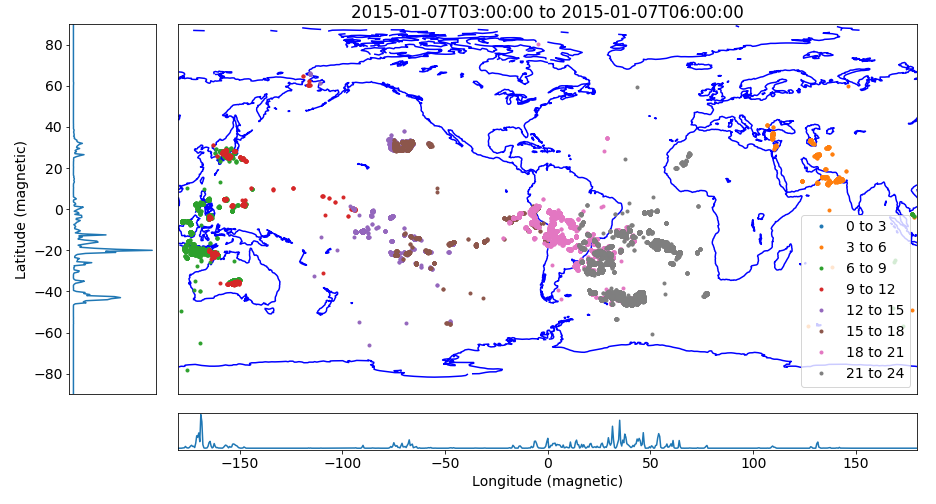

In [222]:
import matplotlib.gridspec as gridspec
# --------------- Latex Plot Beautification --------------------------
fig_width = 12 
fig_height = 6
fig_size =  [fig_width+1,fig_height+1]
params = {'backend': 'ps',
          'axes.labelsize': 14,
          'font.size': 14,
          'legend.fontsize': 14,
          'xtick.labelsize': 14,
          'ytick.labelsize': 14,
          'text.usetex': False,
          'figure.figsize': fig_size}
plt.rcParams.update(params)
# --------------- Latex Plot Beautification --------------------------

gridlats = np.arange(-90, 90, cellsize)
gridlons = np.arange(-180, 180, cellsize)
gridmlts = np.linspace(0,24, 9) #np.array([0,6,12,18,24])
dg2 = np.array(data_grid)

# Quantize data into lat, lon, and MLT bins:
dg2[:,0] = np.digitize(dg2[:,0],gridlats)
dg2[:,1] = np.digitize(dg2[:,1]-180.0,gridlons)
dg2[:,2] = np.digitize(dg2[:,2],gridmlts)


# Bin total current by lat and lon
cur_bins = np.zeros([len(gridlons), len(gridlats)])
for row in dg2:
    cur_bins[int(row[1]), int(row[0])] += np.abs(row[3])
    
cur_bylat = np.sum(cur_bins, axis=0)
cur_bylon = np.sum(cur_bins, axis=1)



# Plot flash location with integrated current vs lat and lon:
fig = plt.figure()
gs = gridspec.GridSpec(8,8)
# gs.update(left=0.05, right=0.48, wspace=0.05)
ax1 = plt.subplot(gs[0:-1,1:])
ax0 = plt.subplot(gs[0:-1,0])
ax2 = plt.subplot(gs[-1,1:])

coast_lat_mag, coast_lon_mag = get_coast_mag(in_time)
ax1.plot(coast_lon_mag, coast_lat_mag, 'b')

for v, m in enumerate(gridmlts[1:]):
    ax1.plot(data_grid[dg2[:,2]==v,1]-180.0, data_grid[dg2[:,2]==v,0],'.', label='%d to %d'%(gridmlts[v], m))
# for k in range(nk):
#     ax[0,1].plot(data_grid[idx==k,1], data_grid[idx==k,0],'.')


ax0.plot(cur_bylat,gridlats)
ax0.set_ylim([-90,90])
ax0.set_xticks([])
ax0.set_ylabel('Latitude (magnetic)')
ax2.plot(gridlons, cur_bylon)
ax2.set_xlim([-180,180])
ax2.set_yticks([])
ax2.set_xlabel('Longitude (magnetic)')
# ax1.set_aspect('equal')
ax1.set_yticks([])
ax1.set_xticks([])
ax1.legend()

ax1.set_aspect('equal')
ax1.set_xlim([-180,180])
ax1.set_ylim([-90,90])
# ax[1,0].set_visible(False)
ax1.set_title( (in_time - lookback_time).isoformat() + ' to ' + in_time.isoformat() )
fig.tight_layout()


<IPython.core.display.Javascript object>


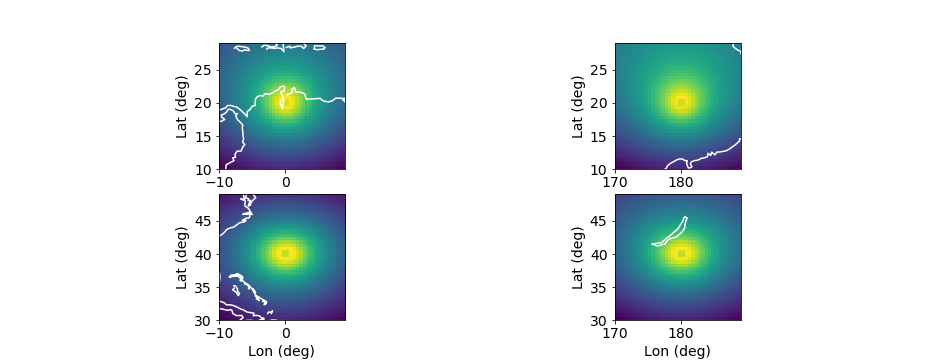

[ 10.   10.5  11.   11.5  12.   12.5  13.   13.5  14.   14.5  15.   15.5
  16.   16.5  17.   17.5  18.   18.5  19.   19.5  20.   20.5  21.   21.5
  22.   22.5  23.   23.5  24.   24.5  25.   25.5  26.   26.5  27.   27.5
  28.   28.5  29.   29.5]
[-10.   -9.5  -9.   -8.5  -8.   -7.5  -7.   -6.5  -6.   -5.5  -5.   -4.5
  -4.   -3.5  -3.   -2.5  -2.   -1.5  -1.   -0.5   0.    0.5   1.    1.5
   2.    2.5   3.    3.5   4.    4.5   5.    5.5   6.    6.5   7.    7.5
   8.    8.5   9.    9.5]
[ 10.   10.5  11.   11.5  12.   12.5  13.   13.5  14.   14.5  15.   15.5
  16.   16.5  17.   17.5  18.   18.5  19.   19.5  20.   20.5  21.   21.5
  22.   22.5  23.   23.5  24.   24.5  25.   25.5  26.   26.5  27.   27.5
  28.   28.5  29.   29.5]
[ 170.   170.5  171.   171.5  172.   172.5  173.   173.5  174.   174.5
  175.   175.5  176.   176.5  177.   177.5  178.   178.5  179.   179.5
  180.   180.5  181.   181.5  182.   182.5  183.   183.5  184.   184.5
  185.   185.5  186.   186.5  187.   187.5  188.   1

In [42]:
fig, ax = plt.subplots(len(in_lats),len(in_MLTs))

ax = ax.flatten()
for ind, key in enumerate(sorted(inp_pwrs.keys())):
    flash_lat = key[0]
    flash_mlt = key[1]
    flash_lon = MLT2lon(itime, flash_mlt, xf)

    d = inp_pwrs[key]
    
    lats = np.arange(flash_lat - lat_spread, flash_lat + lat_spread, cellsize)
    lons = np.arange(flash_lon - lon_spread, flash_lon + lon_spread, cellsize)
    print lats
    print lons
    p = ax[ind].pcolorfast(lons, lats, np.log10(d))
    
    
    ax[ind].plot(coast_lon_mag, coast_lat_mag, 'w')


    ax[ind].set_aspect('equal')
    ax[ind].set_ylabel('Lat (deg)')
    ax[ind].set_xlabel('Lon (deg)')
    ax[ind].set_xlim([flash_lon - lon_spread, flash_lon + lon_spread-1])
    ax[ind].set_ylim([flash_lat - lat_spread, flash_lat + lat_spread-1])
    
# ax.imshow(np.log10(data))

In [33]:
key = (in_lat, in_MLT)

inp_pwrs[key] = data
key2 = (40, 0)
inp_pwrs[key2] = data

In [278]:
# Calculate database of input illumination:
from graf_iono_absorp import total_input_power, lon2MLT, MLT2lon, input_power_scaling
# Constants
Hz2Rad = 2.*np.pi
D2R = np.pi/180.
H_IONO_BOTTOM = 1e5
H_IONO_TOP = 1e6
R_E = 6371e3

num_cores = multiprocessing.cpu_count()


in_lats = np.array([20, 40]) # Geomagnetic pls
in_MLTs = np.array([0, 12])
itime = datetime.datetime(2010,1,1,0,0,0)

I0 = 1.

lat_spread = 10
lon_spread = 10
cellsize = 0.5

opts = dict()
opts['epsabs']= 1.5e-8
opts['epsrel']= 1.5e-8
opts['limit']= 10

def integrand(inlat, inlon, inw, itime, I0, flash_pos_sm_in, itime_in):
    mlt = lon2MLT(itime, inlon, xf);
    tmp_coords = [1, inlat, inlon];
    x_sm = xf.rllmag2sm(tmp_coords, itime_in);

    pwr = input_power_scaling(flash_pos_sm_in, x_sm, inlat, inw, I0, mlt, xf);
    return pwr*(R_E + H_IONO_TOP)*D2R*(R_E + H_IONO_TOP)*np.cos(D2R*inlat)*D2R

n_inlats = len(in_lats)
n_inmlt  = len(in_MLTs)
n_freq_pairs = len(freq_pairs)

f1 = 200; f2 = 30000
w_pair = (Hz2Rad*f1, Hz2Rad*f2)

inp_pwrs = dict()

for in_lat in in_lats:
    for in_MLT in in_MLTs:
        in_lon = MLT2lon(itime, in_MLT, xf)
        print in_lat, in_lon
        
        grid_lats = np.arange(in_lat - lat_spread, in_lat + lat_spread, cellsize)
        grid_lons = np.arange(in_lon - lon_spread, in_lon + lon_spread, cellsize)
        
        n_gridlats = len(grid_lats)
        n_gridlons = len(grid_lons)
        print n_gridlats, n_gridlons
        lat_pairs  = zip(grid_lats[0:-1], grid_lats[1:])
        lon_pairs  = zip(grid_lons[0:-1], grid_lons[1:])

        flash_pos_mag = [1, in_lat, in_lon]
        flash_pos_sm = xf.rllmag2sm(flash_pos_mag, itime)
        
        # Fresh array
        data = np.zeros([n_gridlats -1 , n_gridlons - 1])
        
        # Do the power calculation at each cell:
        for lat_ind, lat_pair in enumerate(lat_pairs):
            print in_lat, in_MLT, lat_pair
            def job_inp(lp):
                return nquad(integrand, [lat_pair, lp, w_pair], args=[itime, I0, flash_pos_sm, itime],
                              opts=opts, full_output=False)[0]

            integ = Parallel(n_jobs=num_cores)(delayed(job_inp)(lon_pair) for lon_pair in lon_pairs)
#             print "integ has shape:", np.shape(integ)
#             print "data has shape:", np.shape(data)
            data[lat_ind, :] = integ
     
        key = (in_lat, in_MLT)
        inp_pwrs[key] = data

NameError: name 'freq_pairs' is not defined

In [230]:
# Cluster via K-means:
from scipy.cluster.vq import kmeans,vq
# data_grid = np.array(data_grid)
# d3 = data_grid[:,[0,1,2,4]]  # Lat, Lon, MLT, KPmax

# K-means on lat, lon pairs:
nk = 100
relevant_columns = [0,1,2] # lat, lon, MLT
centroids, _ = kmeans(data_grid[:,relevant_columns], nk)  # find centers 
idx, _ = vq(data_grid[:,relevant_columns], centroids)     # Quantize into bins

In [4]:
from GLD_file_tools import GLD_file_tools

GLD_path = '/home/asousa/GLD_mount/'
gld = GLD_file_tools(GLD_path, prefix='GLD')

# The time we want to get flashes at
in_time = datetime.datetime(2015,3,6,23,59,0)

# How far back before in_time do we want to look for
lookback_time = datetime.timedelta(hours=3)

# # Flashes is a numpy array: columns are:
# # (year) (month) (day) (hour) (minute) (second) (nanoseconds) (latitude) (longitude) (I0) 

# flashes, flash_times = gld.load_flashes(in_time, lookback_time)
# print np.shape(flashes)



(192708, 10)


In [8]:
test_grid = np.zeros([180,360,365*8])
test_grid.nbytes/1024./1024.

1443.603515625